## Exploration_10_텍스트요약
#### 순서
Step 1. 데이터 수집 <br>
Step 2. 전처리 <br>
Step 3. Attention 메커니즘 사용 (abstractive) <br>
Step 4. 실제결과와 요약문 비교 <br>
Step 5. Summa 사용 (extractive) <br>
Step 6. 회고

### Step 1. 데이터 수집

In [152]:
import nltk
nltk.download('stopwords')

import numpy as np
import pandas as pd
import os
import re
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from bs4 import BeautifulSoup 
from tensorflow.keras.preprocessing.text import Tokenizer 
from tensorflow.keras.preprocessing.sequence import pad_sequences
import urllib.request

[nltk_data] Downloading package stopwords to /aiffel/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [153]:
import urllib.request
urllib.request.urlretrieve("https://raw.githubusercontent.com/sunnysai12345/News_Summary/master/news_summary_more.csv", filename="news_summary_more.csv")
data = pd.read_csv('news_summary_more.csv', encoding='iso-8859-1')

In [154]:
data.sample(10)

,headlines,text
80844,Scientists store a movie in living bacteria fo...,"In a first, Harvard scientists have encoded a ..."
40762,Priority stays with nation: Virat Kohli on Afr...,Reacting to former Pakistan captain Shahid Afr...
77994,4 foreign nationals held with drugs worth Ã¢Â...,Three African women and a man were arrested by...
83638,Terrorist plot targeting Grand Mosque in Mecca...,Saudi Arabia's security forces on Friday foile...
78269,Israeli stink bomb fails tests to control crow...,An Israeli crowd control stink bomb which smel...
82133,Indian Air Force helicopter goes missing in Ar...,The Indian Air Force's Advanced Light Helicopt...
92801,Malaysia Airlines world's 1st to satellite-tra...,Malaysia Airlines will become the world's firs...
56743,Microsoft pledges $50 mn to broaden AI for Ear...,Microsoft has pledged $50 million over the nex...
67351,UK swears in its first female President of Sup...,Brenda Hale has been sworn in as the first fem...
26199,Mufti warns of dangerous results if Delhi trie...,Former J&K CM and PDP chief Mehbooba Mufti on ...


* 데이터의 형태 확인. 원문과 헤드라인으로 구성 되어 있다.

In [155]:
# 전체 데이터 수
len(data)

98401

### Step 2. 데이터 전처리

In [156]:
# 중복 제외 데이터 수
print('Text 열에서 중복을 배제한 유일한 샘플의 수 :', data['text'].nunique())
print('Headlines 열에서 중복을 배제한 유일한 샘플의 수 :', data['headlines'].nunique())

Text 열에서 중복을 배제한 유일한 샘플의 수 : 98360
Headlines 열에서 중복을 배제한 유일한 샘플의 수 : 98280


In [157]:
# text column 중복 제거
data.drop_duplicates(subset = ['text'], inplace=True)
print('전체 샘플수 :', (len(data)))

전체 샘플수 : 98360


In [158]:
# null 확인
print(data.isnull().sum())

headlines    0
text         0
dtype: int64


* 전체 데이터에서 중복을 제거하고 null 값의 유무 확인

#### 정규화 사전

In [159]:
# 텍스트 정규화를 위한 정규화 사전 구성
contractions = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not",
                           "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not",
                           "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",
                           "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would",
                           "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would",
                           "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam",
                           "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have",
                           "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock",
                           "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have",
                           "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is",
                           "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as",
                           "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would",
                           "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have",
                           "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have",
                           "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are",
                           "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",
                           "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is",
                           "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have",
                           "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have",
                           "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all",
                           "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have",
                           "you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have",
                           "you're": "you are", "you've": "you have"}

print("정규화 사전의 수: ", len(contractions))

정규화 사전의 수:  120


* 연산 속도를 높이기 위한 정규화 사전 생성. 문장의 형식을 통일화 시킨다

#### 불용어 확인, 제거

In [160]:
# 불용어 (stopwords) 확인
print('불용어 개수 :', len(stopwords.words('english') ))
print(stopwords.words('english'))

불용어 개수 : 179
['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 's

In [161]:
# 데이터 전처리 함수
def preprocess_sentence(sentence, remove_stopwords=True):
    sentence = sentence.lower() # 텍스트 소문자화
    sentence = BeautifulSoup(sentence, "lxml").text # <br />, <a href = ...> 등의 html 태그 제거
    sentence = re.sub(r'\([^)]*\)', '', sentence) # 괄호로 닫힌 문자열 (...) 제거 Ex) my husband (and myself!) for => my husband for
    sentence = re.sub('"','', sentence) # 쌍따옴표 " 제거
    sentence = ' '.join([contractions[t] if t in contractions else t for t in sentence.split(" ")]) # 약어 정규화
    sentence = re.sub(r"'s\b","", sentence) # 소유격 제거. Ex) roland's -> roland
    sentence = re.sub("[^a-zA-Z]", " ", sentence) # 영어 외 문자(숫자, 특수문자 등) 공백으로 변환
    sentence = re.sub('[m]{2,}', 'mm', sentence) # m이 3개 이상이면 2개로 변경. Ex) ummmmmmm yeah -> umm yeah
    
    # 불용어 제거 (Text)
    if remove_stopwords:
        tokens = ' '.join(word for word in sentence.split() if not word in stopwords.words('english') if len(word) > 1)
    # 불용어 미제거 (Summary)
    else:
        tokens = ' '.join(word for word in sentence.split() if len(word) > 1)
    return tokens

In [162]:
# 데이터 전처리 함수 작동 확인
temp_text = 'Everything I bought was great, infact I ordered twice and the third ordered was<br />for my mother and father.'
temp_summary = 'Great way to start (or finish) the day!!!'

print(preprocess_sentence(temp_text))
print(preprocess_sentence(temp_summary, False))  # 불용어를 제거하지 않습니다.

everything bought great infact ordered twice third ordered wasfor mother father
great way to start the day


* 각 문장에 대한 각종 전처리를 진행. 임의의 텍스트를 통한 정상 처리 여부 확인

In [163]:
import multiprocessing as mp   # 멀티 프로세싱으로 전처리 속도를 획기적으로 줄여봅시다
from multiprocessing import Pool
import numpy as np
import time
from functools import partial  # map을 할 때 함수에 여러 인자를 넣어줄 수 있도록 합니다

start = time.time()

# num_cores 만큼 쪼개진 데이터를 전처리하여 반환합니다
def appendTexts(sentences, remove_stopwords):
  texts = []
  for s in sentences:
    texts += preprocess_sentence(s, remove_stopwords),
  return texts

def preprocess_data(data, remove_stopwords=True):
  start_time = time.time()
  num_cores = mp.cpu_count()  # 컴퓨터의 코어 수를 구합니다

  text_data_split = np.array_split(data, num_cores)  # 코어 수만큼 데이터를 배분하여 병렬적으로 처리할 수 있게 합니다
  pool = Pool(num_cores)

  processed_data = np.concatenate(pool.map(partial(appendTexts, remove_stopwords=remove_stopwords), text_data_split))  # 각자 작업한 데이터를 하나로 합쳐줍니다
  pool.close()
  pool.join()
  print(time.time() - start_time, " seconds")
  return processed_data

# text 전처리
clean_text = preprocess_data(data['text'])
print(clean_text)

# headlines 전처리
clean_summary = preprocess_data(data['headlines'], remove_stopwords=False)
print(clean_summary)

177.30295276641846  seconds
['saurav kant alumnus upgrad iiit pg program machine learning artificial intelligence sr systems engineer infosys almost years work experience program upgrad degree career support helped transition data scientist tech mahindra salary hike upgrad online power learning powered lakh careers'
 'kunal shah credit card bill payment platform cred gave users chance win free food swiggy one year pranav kaushik delhi techie bagged reward spending cred coins users get one cred coin per rupee bill paid used avail rewards brands like ixigo bookmyshow ubereats cult fit'
 'new zealand defeated india wickets fourth odi hamilton thursday win first match five match odi series india lost international match rohit sharma captaincy consecutive victories dating back march match witnessed india getting seventh lowest total odi cricket history'
 ...
 'according reports new version science fiction film matrix development michael jordan reportedly play lead role film screenwriter zak

In [164]:
# 기존의 data를 전처리 된 data로 치환
data['text'] = clean_text
data['headlines'] = clean_summary

# 빈 값을 Null 값으로 변환
data.replace('', np.nan, inplace=True)

In [165]:
# null 값 재 확인
data.isnull().sum()

headlines    0
text         0
dtype: int64

In [166]:
data.dropna(axis=0, inplace=True)
print('전체 샘플수 :', (len(data)))

전체 샘플수 : 98360


* 불용어 제거 및 각종 처리 된 문장의 null 값 재확인. 전체 샘플수 재확인

텍스트의 최소 길이 : 1
텍스트의 최대 길이 : 60
텍스트의 평균 길이 : 35.09968483123221
헤드라인의 최소 길이 : 1
헤드라인의 최대 길이 : 16
헤드라인의 평균 길이 : 9.299532330215534


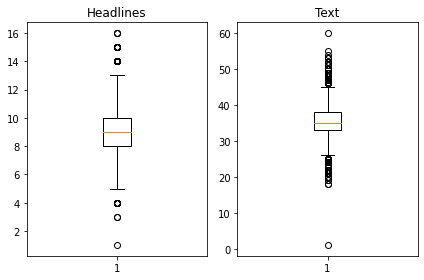

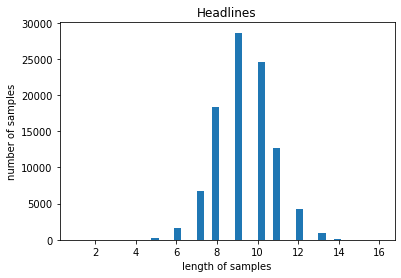

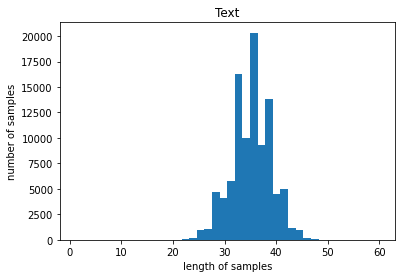

In [167]:
# 길이 분포 출력
import matplotlib.pyplot as plt

text_len = [len(s.split()) for s in data['text']]
headlines_len = [len(s.split()) for s in data['headlines']]

print('텍스트의 최소 길이 : {}'.format(np.min(text_len)))
print('텍스트의 최대 길이 : {}'.format(np.max(text_len)))
print('텍스트의 평균 길이 : {}'.format(np.mean(text_len)))
print('헤드라인의 최소 길이 : {}'.format(np.min(headlines_len)))
print('헤드라인의 최대 길이 : {}'.format(np.max(headlines_len)))
print('헤드라인의 평균 길이 : {}'.format(np.mean(headlines_len)))

plt.subplot(1,2,1)
plt.boxplot(headlines_len)
plt.title('Headlines')
plt.subplot(1,2,2)
plt.boxplot(text_len)
plt.title('Text')
plt.tight_layout()
plt.show()

plt.title('Headlines')
plt.hist(headlines_len, bins = 40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

plt.title('Text')
plt.hist(text_len, bins = 40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

* sample들의 길이가 정규분포의 형태를 띄고, 크게 벗어나는 값이 없어서 사용할 데이터의 길이를 제한하지 않고 그대로 사용하였다.

In [168]:
# 요약 데이터에는 시작 토큰과 종료 토큰을 추가한다.
data['decoder_input'] = data['headlines'].apply(lambda x : 'sostoken '+ x)
data['decoder_target'] = data['headlines'].apply(lambda x : x + ' eostoken')
data.head()

,headlines,text,decoder_input,decoder_target
0,upgrad learner switches to career in ml al wit...,saurav kant alumnus upgrad iiit pg program mac...,sostoken upgrad learner switches to career in ...,upgrad learner switches to career in ml al wit...
1,delhi techie wins free food from swiggy for on...,kunal shah credit card bill payment platform c...,sostoken delhi techie wins free food from swig...,delhi techie wins free food from swiggy for on...
2,new zealand end rohit sharma led india match w...,new zealand defeated india wickets fourth odi ...,sostoken new zealand end rohit sharma led indi...,new zealand end rohit sharma led india match w...
3,aegon life iterm insurance plan helps customer...,aegon life iterm insurance plan customers enjo...,sostoken aegon life iterm insurance plan helps...,aegon life iterm insurance plan helps customer...
4,have known hirani for yrs what if metoo claims...,speaking sexual harassment allegations rajkuma...,sostoken have known hirani for yrs what if met...,have known hirani for yrs what if metoo claims...


* 'decoder_input'의 앞에 'sostoken' 을 추가, 'decoder_target'의 끝에는 'eostoken'을 추가

#### Train, Test set 분리

In [169]:
# numpy 형태로 변경
encoder_input = np.array(data['text']) # 인코더의 입력
decoder_input = np.array(data['decoder_input']) # 디코더의 입력
decoder_target = np.array(data['decoder_target']) # 디코더의 레이블

In [170]:
# shape 확인
print(encoder_input.shape)
print(decoder_input.shape)
print(decoder_target.shape)

(98360,)
(98360,)
(98360,)


In [171]:
# 랜덤으로 값을 배분하기 위한 shuffle 진행
indices = np.arange(encoder_input.shape[0])
np.random.shuffle(indices)
print(indices)
print(len(indices))

[25015 88124 89348 ... 67353 22171 70491]
98360


In [172]:
# shuffle 된 값으로 치환
encoder_input = encoder_input[indices]
decoder_input = decoder_input[indices]
decoder_target = decoder_target[indices]

In [173]:
# 'train : test = 8 : 2' 비율로  set 구성
n_of_val = int(len(encoder_input)*0.2)
print('테스트 데이터의 수 :', n_of_val)

# train set
encoder_input_train = encoder_input[:-n_of_val]
decoder_input_train = decoder_input[:-n_of_val]
decoder_target_train = decoder_target[:-n_of_val]

# test set
encoder_input_test = encoder_input[-n_of_val:]
decoder_input_test = decoder_input[-n_of_val:]
decoder_target_test = decoder_target[-n_of_val:]

print('훈련 데이터의 개수 :', len(encoder_input_train))
print('훈련 레이블의 개수 :', len(decoder_input_train))
print('테스트 데이터의 개수 :', len(encoder_input_test))
print('테스트 레이블의 개수 :', len(decoder_input_test))

테스트 데이터의 수 : 19672
훈련 데이터의 개수 : 78688
훈련 레이블의 개수 : 78688
테스트 데이터의 개수 : 19672
테스트 레이블의 개수 : 19672


#### 단어집합 (vocabulary) 만들기 : Tokenization

In [174]:
# 'Text' 에 대한 처리 시작
src_tokenizer = Tokenizer() # 토크나이저 정의
src_tokenizer.fit_on_texts(encoder_input_train) # 입력된 데이터로부터 단어 집합 생성

In [175]:
# 토큰화가 잘 되었는지 확인
list(src_tokenizer.word_index.items())[:10]

[('said', 1),
 ('india', 2),
 ('year', 3),
 ('added', 4),
 ('us', 5),
 ('also', 6),
 ('first', 7),
 ('government', 8),
 ('police', 9),
 ('people', 10)]

* 전체 중에 가장 앞쪽의 10개 정도만 출력해서 key, value 값을 확인 해 보면 정상적으로 입력 되어 있음을 알 수 있다.

In [26]:
# 빈도수에 따른 단어의 중요도 확인

threshold = 7 # 빈도수 제한 : 7 미만
total_cnt = len(src_tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in src_tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :', total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print('단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 %s'%(total_cnt - rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 69561
등장 빈도가 6번 이하인 희귀 단어의 수: 47377
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 22184
단어 집합에서 희귀 단어의 비율: 68.10856658184903
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 3.485688079438317


* 단어 집합에서는 희귀 단어의 비율이 70% 정도를 차지하는 반면 전체 단어의 등장 빈도수 대비 희귀 단어는 3.5% 정도 밖에 되지 않기 때문에 제거하고 단어집합의 크기를 대폭 낮추는 방향으로 진행하도록 한다.

In [27]:
src_vocab = 22000 # 단어 집합크기 제한
src_tokenizer = Tokenizer(num_words=src_vocab) # 단어 집합의 크기를 22,000로 제한
src_tokenizer.fit_on_texts(encoder_input_train) # 단어 집합 재생성.

* 단어 집합의 크기는 희귀 단어가 제거 됐을 때의 단어 집합 크기를 고려하여 22000개로 제한한다

In [28]:
# 텍스트 시퀀스를 정수 시퀀스로 변환
encoder_input_train = src_tokenizer.texts_to_sequences(encoder_input_train) 
encoder_input_test = src_tokenizer.texts_to_sequences(encoder_input_test)

# 잘 진행되었는지 샘플 출력
print(encoder_input_train[:3])

[[316, 751, 14817, 1259, 1304, 1493, 1718, 1, 1259, 318, 2270, 1352, 201, 215, 1493, 1, 4653, 3544, 5499, 1390, 165, 10738, 4654, 1, 6, 14817, 1259, 594, 793, 1133, 273, 779], [549, 1218, 52, 15383, 1194, 354, 142, 867, 312, 473, 1066, 197, 91, 8874, 846, 2700, 2088, 145, 197, 8131, 15383, 1369, 243, 696, 71, 799, 1260, 4503, 10034, 4503, 1476, 672, 197, 6, 8131, 15383, 110, 6402, 5882, 12964, 13796, 1369], [5, 16, 126, 44, 1183, 14818, 15384, 40, 371, 5235, 3020, 10035, 244, 1756, 16, 233, 14284, 674, 983, 586, 278, 16700, 672, 233, 1756, 16, 13797, 15384, 1, 10035, 2097, 1050, 10486, 339, 44, 529]]


In [29]:
# 'Headlines' 에 대해 동일하게 처리
tar_tokenizer = Tokenizer()
tar_tokenizer.fit_on_texts(decoder_input_train)

In [30]:
threshold = 7
total_cnt = len(tar_tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in tar_tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :', total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print('단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 %s'%(total_cnt - rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 30070
등장 빈도가 6번 이하인 희귀 단어의 수: 20563
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 9507
단어 집합에서 희귀 단어의 비율: 68.3837712005321
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 5.309128423328426


* 'text'와 마찬가지로 'headlines' 데이터에 대해서도 단어 집합의 크기를 9500으로 재조정한다.

In [31]:
tar_vocab = 9500 # 위의 결과에 따라 설정
tar_tokenizer = Tokenizer(num_words=tar_vocab) 
tar_tokenizer.fit_on_texts(decoder_input_train)
tar_tokenizer.fit_on_texts(decoder_target_train)

In [182]:
# 텍스트 시퀀스를 정수 시퀀스로 변환
decoder_input_train = tar_tokenizer.texts_to_sequences(decoder_input_train) 
decoder_target_train = tar_tokenizer.texts_to_sequences(decoder_target_train)
decoder_input_test = tar_tokenizer.texts_to_sequences(decoder_input_test)
decoder_target_test = tar_tokenizer.texts_to_sequences(decoder_target_test)

# 잘 변환되었는지 확인
print('input')
print('input ',decoder_input_train[:5])
print('target')
print('decoder ',decoder_target_train[:5])

input
input  [[1, 9, 141, 143, 6, 859, 463, 1198], [1, 5420, 92, 4, 1224, 52, 2487, 4, 101, 209, 2208], [1, 44, 697, 2970, 7, 158, 1294, 659, 193], [1, 84, 1558, 3331, 5, 2862], [1, 65, 2971, 924, 202, 1008, 1387, 96, 1033]]
target
decoder  [[9, 141, 143, 6, 859, 463, 1198, 2], [5420, 92, 4, 1224, 52, 2487, 4, 101, 209, 2208, 2], [44, 697, 2970, 7, 158, 1294, 659, 193, 2], [84, 1558, 3331, 5, 2862, 2], [65, 2971, 924, 202, 1008, 1387, 96, 1033, 2]]


* 'input' 에는 1 이 처음에 들어가있고, 'target' 에는 2 가 끝에 들어가 있는 것을 볼 수 있다. 각각 sostoken, eostoken 을 뜻한다.

In [183]:
# 문장의 길이가 1 인 것들은 'sostoken' or 'eostoken' 만 남은 것이므로 제거
drop_train = [index for index, sentence in enumerate(decoder_input_train) if len(sentence) == 1]
drop_test = [index for index, sentence in enumerate(decoder_input_test) if len(sentence) == 1]

print('삭제할 훈련 데이터의 개수 :', len(drop_train))
print('삭제할 테스트 데이터의 개수 :', len(drop_test))

삭제할 훈련 데이터의 개수 : 1
삭제할 테스트 데이터의 개수 : 0


In [184]:
# drop_train, drop_test 에 대한 값을 제거
encoder_input_train = np.delete(encoder_input_train, drop_train, axis=0)
decoder_input_train = np.delete(decoder_input_train, drop_train, axis=0)
decoder_target_train = np.delete(decoder_target_train, drop_train, axis=0)

encoder_input_test = np.delete(encoder_input_test, drop_test, axis=0)
decoder_input_test = np.delete(decoder_input_test, drop_test, axis=0)
decoder_target_test = np.delete(decoder_target_test, drop_test, axis=0)

print('훈련 데이터의 개수 :', len(encoder_input_train))
print('훈련 레이블의 개수 :', len(decoder_input_train))
print('테스트 데이터의 개수 :', len(encoder_input_test))
print('테스트 레이블의 개수 :', len(decoder_input_test))

훈련 데이터의 개수 : 78687
훈련 레이블의 개수 : 78687
테스트 데이터의 개수 : 19672
테스트 레이블의 개수 : 19672


/opt/conda/lib/python3.7/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


#### 패딩 추가

In [185]:
text_max_len = 60
headlines_max_len = 16
encoder_input_train = pad_sequences(encoder_input_train, maxlen=text_max_len, padding='post')
encoder_input_test = pad_sequences(encoder_input_test, maxlen=text_max_len, padding='post')
decoder_input_train = pad_sequences(decoder_input_train, maxlen=headlines_max_len, padding='post')
decoder_target_train = pad_sequences(decoder_target_train, maxlen=headlines_max_len, padding='post')
decoder_input_test = pad_sequences(decoder_input_test, maxlen=headlines_max_len, padding='post')
decoder_target_test = pad_sequences(decoder_target_test, maxlen=headlines_max_len, padding='post')

In [186]:
encoder_input_train # 확인

array([[   2, 2433,  733, ...,    0,    0,    0],
       [ 211,  353,  196, ...,    0,    0,    0],
       [ 536,  137, 1171, ...,    0,    0,    0],
       ...,
       [ 156,   56,  425, ...,    0,    0,    0],
       [2471, 2761, 3906, ...,    0,    0,    0],
       [  76,   36, 2310, ...,    0,    0,    0]], dtype=int32)

* post 에 패딩이 추가 된 것을 확인 할 수 있다.

#### Model 설계 (Encoder, decoder 설계)

In [187]:
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint


# 인코더 설계 시작
embedding_dim = 128
hidden_size = 256 # LSTM 의 capacity에 해당(뉴런의 갯수) but 크다고 항상 좋지않다.

# 인코더
encoder_inputs = Input(shape=(text_max_len,))

# 인코더의 임베딩 층
enc_emb = Embedding(src_vocab, embedding_dim)(encoder_inputs)

# 인코더의 LSTM 1
encoder_lstm1 = LSTM(hidden_size, return_sequences=True, return_state=True ,dropout = 0.4, recurrent_dropout = 0.4)
encoder_output1, state_h1, state_c1 = encoder_lstm1(enc_emb)

# 인코더의 LSTM 2
encoder_lstm2 = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4, recurrent_dropout=0.4)
encoder_output2, state_h2, state_c2 = encoder_lstm2(encoder_output1)

# 인코더의 LSTM 3
encoder_lstm3 = LSTM(hidden_size, return_state=True, return_sequences=True, dropout=0.4, recurrent_dropout=0.4)
encoder_outputs, state_h, state_c= encoder_lstm3(encoder_output2)

In [188]:
# 디코더 설계
decoder_inputs = Input(shape=(None,))

# 디코더의 임베딩 층
dec_emb_layer = Embedding(tar_vocab, embedding_dim)
dec_emb = dec_emb_layer(decoder_inputs)

# 디코더의 LSTM
decoder_lstm = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4, recurrent_dropout=0.2)
decoder_outputs, _, _ = decoder_lstm(dec_emb, initial_state=[state_h, state_c])

In [189]:
# 디코더의 출력층
decoder_softmax_layer = Dense(tar_vocab, activation='softmax')
decoder_softmax_outputs = decoder_softmax_layer(decoder_outputs) 

# 모델 정의
model = Model([encoder_inputs, decoder_inputs], decoder_softmax_outputs)
model.summary()

Model: "model_8"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_9 (InputLayer)            [(None, 60)]         0                                            
__________________________________________________________________________________________________
embedding_8 (Embedding)         (None, 60, 128)      1280000     input_9[0][0]                    
__________________________________________________________________________________________________
lstm_16 (LSTM)                  [(None, 60, 256), (N 394240      embedding_8[0][0]                
__________________________________________________________________________________________________
input_10 (InputLayer)           [(None, None)]       0                                            
____________________________________________________________________________________________

* 기본적인 인코더, 디코더를 설정했다

### Step 3. Attention 함수 추가

In [190]:
# Attention 함수 참조
urllib.request.urlretrieve("https://raw.githubusercontent.com/thushv89/attention_keras/master/src/layers/attention.py", filename="attention.py")
from attention import AttentionLayer

In [191]:
# 어텐션 층(어텐션 함수)
attn_layer = AttentionLayer(name='attention_layer')
# 인코더와 디코더의 모든 time step의 hidden state를 어텐션 층에 전달하고 결과를 리턴
attn_out, attn_states = attn_layer([encoder_outputs, decoder_outputs])

# 어텐션의 결과와 디코더의 hidden state들을 연결
decoder_concat_input = Concatenate(axis=-1, name='concat_layer')([decoder_outputs, attn_out])

# 디코더의 출력층
decoder_softmax_layer = Dense(tar_vocab, activation='softmax')
decoder_softmax_outputs = decoder_softmax_layer(decoder_concat_input)

# 모델 정의
model = Model([encoder_inputs, decoder_inputs], decoder_softmax_outputs)
model.summary()

Model: "model_9"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_9 (InputLayer)            [(None, 60)]         0                                            
__________________________________________________________________________________________________
embedding_8 (Embedding)         (None, 60, 128)      1280000     input_9[0][0]                    
__________________________________________________________________________________________________
lstm_16 (LSTM)                  [(None, 60, 256), (N 394240      embedding_8[0][0]                
__________________________________________________________________________________________________
input_10 (InputLayer)           [(None, None)]       0                                            
____________________________________________________________________________________________

#### Model 훈련

In [44]:
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy')
es = EarlyStopping(monitor='val_loss', patience=2, verbose=1) # 조기 종료 조건 설정
history = model.fit(x=[encoder_input_train, decoder_input_train], y=decoder_target_train, \
          validation_data=([encoder_input_test, decoder_input_test], decoder_target_test), \
          batch_size=256, callbacks=[es], epochs=50)

Epoch 1/50
308/308 [==============================] - 306s 958ms/step - loss: 4.6453 - val_loss: 3.9140
Epoch 2/50
308/308 [==============================] - 299s 972ms/step - loss: 3.8513 - val_loss: 3.5880
Epoch 3/50
308/308 [==============================] - 297s 965ms/step - loss: 3.5442 - val_loss: 3.4020
Epoch 4/50
308/308 [==============================] - 297s 965ms/step - loss: 3.3347 - val_loss: 3.2594
Epoch 5/50
308/308 [==============================] - 295s 959ms/step - loss: 3.1714 - val_loss: 3.1454
Epoch 6/50
308/308 [==============================] - 293s 951ms/step - loss: 3.0413 - val_loss: 3.0650
Epoch 7/50
308/308 [==============================] - 289s 939ms/step - loss: 2.9212 - val_loss: 3.0016
Epoch 8/50
308/308 [==============================] - 290s 940ms/step - loss: 2.8276 - val_loss: 2.9360
Epoch 9/50
308/308 [==============================] - 292s 949ms/step - loss: 2.7297 - val_loss: 2.8886
Epoch 10/50
308/308 [==============================] - 290s 941m

* EarlyStopping 을 추가하여 진행 중에 loss 값이 감소가 아닌 증가가 2회 일어나는 경우, 조기 종료하도록 설정

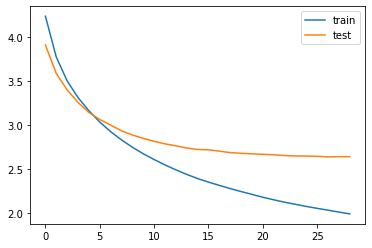

In [45]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

* test 의 loss 값이 줄어들지 않는 문제가 생긴것을 볼 수 있다 (overfitting or 다른 문제).
* 일단 결과값까지 확인 해 보고 다시 학습 할 필요가 있다고 생각 되면 parameter 들을 조절 해 보려고 한다.

In [194]:
src_index_to_word = src_tokenizer.index_word # 원문 단어 집합에서 정수 -> 단어를 얻음
tar_word_to_index = tar_tokenizer.word_index # 요약 단어 집합에서 단어 -> 정수를 얻음
tar_index_to_word = tar_tokenizer.index_word # 요약 단어 집합에서 정수 -> 단어를 얻음

In [195]:
# 인코더 설계
encoder_model = Model(inputs=encoder_inputs, outputs=[encoder_outputs, state_h, state_c])

# 이전 시점의 상태들을 저장하는 텐서
decoder_state_input_h = Input(shape=(hidden_size,))
decoder_state_input_c = Input(shape=(hidden_size,))

dec_emb2 = dec_emb_layer(decoder_inputs)

# 문장의 다음 단어를 예측하기 위해서 초기 상태(initial_state)를 이전 시점의 상태로 사용. 이는 뒤의 함수 decode_sequence()에 구현
# 훈련 과정에서와 달리 LSTM의 리턴하는 은닉 상태와 셀 상태인 state_h와 state_c를 버리지 않음.
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=[decoder_state_input_h, decoder_state_input_c])

In [196]:
# 어텐션 함수
decoder_hidden_state_input = Input(shape=(text_max_len, hidden_size))
attn_out_inf, attn_states_inf = attn_layer([decoder_hidden_state_input, decoder_outputs2])
decoder_inf_concat = Concatenate(axis=-1, name='concat')([decoder_outputs2, attn_out_inf])

# 디코더의 출력층
decoder_outputs2 = decoder_softmax_layer(decoder_inf_concat) 

# 최종 디코더 모델
decoder_model = Model(
    [decoder_inputs] + [decoder_hidden_state_input,decoder_state_input_h, decoder_state_input_c],
    [decoder_outputs2] + [state_h2, state_c2])

In [197]:
def decode_sequence(input_seq):
    # 입력으로부터 인코더의 상태를 얻음
    e_out, e_h, e_c = encoder_model.predict(input_seq)

     # <SOS>에 해당하는 토큰 생성
    target_seq = np.zeros((1,1))
    target_seq[0, 0] = tar_word_to_index['sostoken']

    stop_condition = False
    decoded_sentence = ''
    while not stop_condition: # stop_condition이 True가 될 때까지 루프 반복

        output_tokens, h, c = decoder_model.predict([target_seq] + [e_out, e_h, e_c])
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_token = tar_index_to_word[sampled_token_index]

        if (sampled_token!='eostoken'):
            decoded_sentence += ' '+sampled_token

        #  <eos>에 도달하거나 최대 길이를 넘으면 중단.
        if (sampled_token == 'eostoken'  or len(decoded_sentence.split()) >= (headlines_max_len-1)):
            stop_condition = True

        # 길이가 1인 타겟 시퀀스를 업데이트
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index

        # 상태를 업데이트 합니다.
        e_h, e_c = h, c

    return decoded_sentence

### Step 4. 실제 결과와 요약문 비교
#### Model test ( attractive summary )

In [50]:
# 원문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq2text(input_seq):
    temp=''
    for i in input_seq:
        if (i!=0):
            temp = temp + src_index_to_word[i]+' '
    return temp

# 요약문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq2headlines(input_seq):
    temp=''
    for i in input_seq:
        if ((i!=0 and i!=tar_word_to_index['sostoken']) and i!=tar_word_to_index['eostoken']):
            temp = temp + tar_index_to_word[i] + ' '
    return temp

In [51]:
for i in range(10):
    print("<원문> :", seq2text(encoder_input_test[i]))
    print("[실제 요약] :", seq2headlines(decoder_input_test[i]))
    print("[예측 요약] :", decode_sequence(encoder_input_test[i].reshape(1, text_max_len)))
    print("\n")

<원문> : legendary spinner shane warne sent home day world cup banned year testing positive banned ex nz captain stephen fleming suspended brief period found guilty using marijuana early ex england rounder ian handed day ban using cannabis 
[실제 요약] : which int cricketers have been banned for drug use 
[예측 요약] :  shane warne warne to ban on wc final ban


<원문> : uruguayan forward luis su rez bit italian defender shoulder group stage match fifa world cup third time su rez career bit opponent first offence coming second su rez suspended football related activity four months following repeat offences 
[실제 요약] : player once bit his rival during world cup match 
[예측 요약] :  player pulls out of wc wc after wc exit from wc


<원문> : bjp appointed kg bopaiah protem speaker ahead karnataka assembly floor test saturday congress spokesperson randeep surjewala termed legislator tainted stating bjp broke convention appointing senior mla protem speaker surjewala alleged bopaiah violated norms disqualifie

* 10개 정도 출력해서 비교해 본 결과 '실제요약'문과 '예측요약'문에 비슷한 단어들이 주로 사용된 경우도 있고 완전 다른 형태로 요약된 경우들도 보인다.
* 전반적으로 예측 된 요약문 만을 가지고는 원문의 내용을 추측하기 힘들었다.
* 따라서 위에서 loss 값을 시각화 하면서 앞서 언급 한 대로 좀더 학습의 정확도를 높일 필요가 있어보인다.

#### Model 재설정 -1 : optimizer 변경

In [42]:
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy') # optimizer -> adam 으로 변경
es = EarlyStopping(monitor='val_loss', patience=2, verbose=1) # 조기 종료 조건 설정
history = model.fit(x=[encoder_input_train, decoder_input_train], y=decoder_target_train, \
          validation_data=([encoder_input_test, decoder_input_test], decoder_target_test), \
          batch_size=256, callbacks=[es], epochs=10)

Epoch 1/10
308/308 [==============================] - 301s 944ms/step - loss: 4.9976 - val_loss: 4.0414
Epoch 2/10
308/308 [==============================] - 298s 969ms/step - loss: 4.0152 - val_loss: 3.7537
Epoch 3/10
308/308 [==============================] - 298s 967ms/step - loss: 3.6857 - val_loss: 3.4270
Epoch 4/10
308/308 [==============================] - 295s 957ms/step - loss: 3.3466 - val_loss: 3.2123
Epoch 5/10
308/308 [==============================] - 291s 944ms/step - loss: 3.0995 - val_loss: 3.0789
Epoch 6/10
308/308 [==============================] - 291s 945ms/step - loss: 2.9126 - val_loss: 2.9721
Epoch 7/10
308/308 [==============================] - 289s 939ms/step - loss: 2.7586 - val_loss: 2.8989
Epoch 8/10
308/308 [==============================] - 290s 941ms/step - loss: 2.6235 - val_loss: 2.8398
Epoch 9/10
308/308 [==============================] - 291s 945ms/step - loss: 2.5090 - val_loss: 2.7942
Epoch 10/10
308/308 [==============================] - 290s 943m

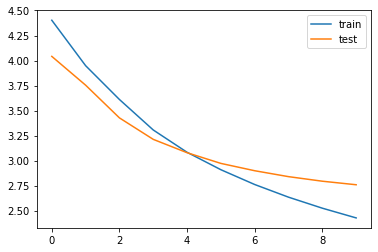

In [43]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

* 10 epochs 기준 'rmsprop' 을 사용했을 때 보다 'adam'을 사용했을 때 loss 값이 조금 더 낮아지는 것을 확인 할 수 있었다.
* 하지만 전체적인 그래프의 성향은 optimizer를 바꿔봐도 크게 달라지는게 없었다.

#### Model 재설정 -2
- 지금 가지고 있는 데이터는 하나하나의 원문의 길이가 그렇게 길지 않다. 하지만 그에 반해 비교하는 단어의 수는 몇 만개가 되기 때문에 상대적으로 accuracy가 낮아질 수 밖에 없는 구조라고 생각된다. 따라서 vocabulary(단어사전) 사이즈를 최대한 줄여서 재실험 해보고자 한다.

In [176]:
threshold = 25 # 빈도수 제한 : 7 미만 -> 25 로 설정한다
total_cnt = len(src_tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in src_tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :', total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print('단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 %s'%(total_cnt - rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 69457
등장 빈도가 24번 이하인 희귀 단어의 수: 58455
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 11002
단어 집합에서 희귀 단어의 비율: 84.15998387491541
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 8.684501249767806


* threshold를 25로 설정해 봤더니 단어집합의 크기가 10000 정도 까지 떨어졌다.
* 희귀 단어의 빈도가 8% 정도 이기 때문에 이 단어들이 생략된다 하더라도 큰 문제는 없을 것 이라 생각 된다.

In [177]:
src_vocab = 10000 # 단어 집합크기 제한
src_tokenizer = Tokenizer(num_words=src_vocab)
src_tokenizer.fit_on_texts(encoder_input_train) # 단어 집합 재생성.

In [178]:
# 텍스트 시퀀스를 정수 시퀀스로 변환
encoder_input_train = src_tokenizer.texts_to_sequences(encoder_input_train) 
encoder_input_test = src_tokenizer.texts_to_sequences(encoder_input_test)

In [179]:
# 'Headlines' 에 대해 동일하게 처리
tar_tokenizer = Tokenizer()
tar_tokenizer.fit_on_texts(decoder_input_train)

In [180]:
threshold = 13 # 기존의 7 -> 13 로 설정한다
total_cnt = len(tar_tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in tar_tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :', total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print('단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 %s'%(total_cnt - rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 30100
등장 빈도가 12번 이하인 희귀 단어의 수: 23610
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 6490
단어 집합에서 희귀 단어의 비율: 78.43853820598007
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 8.698544175158053


* target 데이터 셋에 대해서도 희귀 단어 빈도를 위와 비슷한 8% 대로 맞춰 주기 위해서 threshold를 13으로 설정하였다.

In [181]:
tar_vocab = 6000 # 위의 결과에 따라 설정
tar_tokenizer = Tokenizer(num_words=tar_vocab) 
tar_tokenizer.fit_on_texts(decoder_input_train)
tar_tokenizer.fit_on_texts(decoder_target_train)

* 이 뒤로는 'Model 훈련' 전 까지 위의 기존의 코드로 동일하게 진행한다.

In [148]:
# 변경 된 vocabulary를 이용한 모델 재 훈련
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy') # optimizer = adam
es = EarlyStopping(monitor='val_loss', patience=2, verbose=1) # 조기 종료 조건 설정
history = model.fit(x=[encoder_input_train, decoder_input_train], y=decoder_target_train, \
          validation_data=([encoder_input_test, decoder_input_test], decoder_target_test), \
          batch_size=256, callbacks=[es], epochs=10) # epochs 10으로 테스트

Epoch 1/10
308/308 [==============================] - 284s 889ms/step - loss: 4.6076 - val_loss: 3.7514
Epoch 2/10
308/308 [==============================] - 281s 912ms/step - loss: 3.7218 - val_loss: 3.5069
Epoch 3/10
308/308 [==============================] - 282s 916ms/step - loss: 3.4414 - val_loss: 3.1996
Epoch 4/10
308/308 [==============================] - 282s 914ms/step - loss: 3.1279 - val_loss: 2.9859
Epoch 5/10
308/308 [==============================] - 282s 915ms/step - loss: 2.9029 - val_loss: 2.8524
Epoch 6/10
308/308 [==============================] - 282s 914ms/step - loss: 2.7400 - val_loss: 2.7481
Epoch 7/10
308/308 [==============================] - 283s 919ms/step - loss: 2.6047 - val_loss: 2.6701
Epoch 8/10
308/308 [==============================] - 282s 917ms/step - loss: 2.4894 - val_loss: 2.6103
Epoch 9/10
308/308 [==============================] - 283s 919ms/step - loss: 2.3920 - val_loss: 2.5653
Epoch 10/10
308/308 [==============================] - 283s 918m

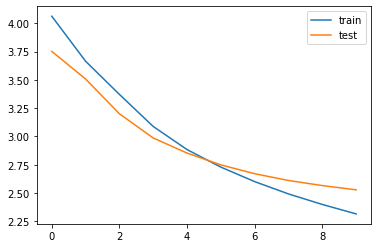

In [149]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

* loss 값이 더 줄어 드는 것을 볼 수 있고, 두 데이터가 좀 더 fitting 되는 것을 볼 수 있다. 이어서 epochs를 늘려서 테스트를 해보도록 한다.

In [192]:
# 변경 된 vocabulary를 이용한 모델 재 훈련
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy') # optimizer = adam
es = EarlyStopping(monitor='val_loss', patience=2, verbose=1) # 조기 종료 조건 설정
history = model.fit(x=[encoder_input_train, decoder_input_train], y=decoder_target_train, \
          validation_data=([encoder_input_test, decoder_input_test], decoder_target_test), \
          batch_size=256, callbacks=[es], epochs=50) # epochs 10으로 테스트

Epoch 1/50
308/308 [==============================] - 286s 894ms/step - loss: 4.6025 - val_loss: 3.7558
Epoch 2/50
308/308 [==============================] - 281s 912ms/step - loss: 3.7344 - val_loss: 3.5685
Epoch 3/50
308/308 [==============================] - 283s 920ms/step - loss: 3.5217 - val_loss: 3.3503
Epoch 4/50
308/308 [==============================] - 283s 919ms/step - loss: 3.3025 - val_loss: 3.1495
Epoch 5/50
308/308 [==============================] - 284s 923ms/step - loss: 3.0845 - val_loss: 2.9949
Epoch 6/50
308/308 [==============================] - 284s 921ms/step - loss: 2.9008 - val_loss: 2.8751
Epoch 7/50
308/308 [==============================] - 281s 913ms/step - loss: 2.7581 - val_loss: 2.7949
Epoch 8/50
308/308 [==============================] - 281s 912ms/step - loss: 2.6385 - val_loss: 2.7280
Epoch 9/50
308/308 [==============================] - 281s 912ms/step - loss: 2.5346 - val_loss: 2.6727
Epoch 10/50
308/308 [==============================] - 281s 913m

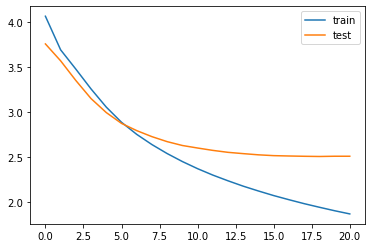

In [193]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

* epoch의 수가 증가함에 따라 비슷한 문제가 다시 발생하는 것을 확인하였다.
* optimizer를 다른 것으로 바꾸거나, 원문의 길이를 늘리는 방식을 통해 어느정도 해결 할 수  있을 것 같다는 생각이 든다.

#### Model Test -2

In [198]:
# 원문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq2text(input_seq):
    temp=''
    for i in input_seq:
        if (i!=0):
            temp = temp + src_index_to_word[i]+' '
    return temp

# 요약문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq2headlines(input_seq):
    temp=''
    for i in input_seq:
        if ((i!=0 and i!=tar_word_to_index['sostoken']) and i!=tar_word_to_index['eostoken']):
            temp = temp + tar_index_to_word[i] + ' '
    return temp

In [199]:
for i in range(10):
    print("<원문> :", seq2text(encoder_input_test[i]))
    print("[실제 요약] :", seq2headlines(decoder_input_test[i]))
    print("[예측 요약] :", decode_sequence(encoder_input_test[i].reshape(1, text_max_len)))
    print("\n")

<원문> : sharing deepika padukone pictures puja home ahead wedding wrote love moon back happy cannot wait start another picture deepika captioned new deepika get married ranveer singh november 
[실제 요약] : deepika organises puja at home ahead of wedding with ranveer 
[예측 요약] :  deepika ranveer to be held at ranveer


<원문> : janhvi kapoor talking late mother actress sridevi said acting like breathing mother knowledge cinema acting think never gave tips watching everything even daily life added janhvi said energy around 
[실제 요약] : acting was like for mom janhvi on sridevi 
[예측 요약] :  wish janhvi khushi is my dream janhvi


<원문> : beats co founders rapper dr jimmy lost million lawsuit steven early developer making company ruled entitled royalties earned headphones based original studio model claimed worked headphones falling founders 
[실제 요약] : beats co founders lose million lawsuit 
[예측 요약] :  billionaire to pay mn to us for mn


<원문> : manchester united first premier league loss season town

* 두 번째 모델 테스트의 결과 또한 첫 번 째와 크게 다르지 않아 보인다. 
* 적당한 문장으로 만들어진 경우도 있지만 그렇지 않은 경우도 많이 보인다.


### Step 5. Summa 사용
#### Extractive summary

In [52]:
import requests
from summa.summarizer import summarize # Extractive summary를 위한 library

In [54]:
data2 = pd.read_csv('news_summary_more.csv', encoding='iso-8859-1')

In [62]:
for idx, text in enumerate(data2['text'][:10]):
    print(f'<Original_{idx+1}:> \n{text}')
    print(f'[Summary:] \n{summarize(text, words=20)}\n')

<Original_1:> 
Saurav Kant, an alumnus of upGrad and IIIT-B's PG Program in Machine learning and Artificial Intelligence, was a Sr Systems Engineer at Infosys with almost 5 years of work experience. The program and upGrad's 360-degree career support helped him transition to a Data Scientist at Tech Mahindra with 90% salary hike. upGrad's Online Power Learning has powered 3 lakh+ careers.
[Summary:] 
The program and upGrad's 360-degree career support helped him transition to a Data Scientist at Tech Mahindra with 90% salary hike.
upGrad's Online Power Learning has powered 3 lakh+ careers.

<Original_2:> 
Kunal Shah's credit card bill payment platform, CRED, gave users a chance to win free food from Swiggy for one year. Pranav Kaushik, a Delhi techie, bagged this reward after spending 2000 CRED coins. Users get one CRED coin per rupee of bill paid, which can be used to avail rewards from brands like Ixigo, BookMyShow, UberEats, Cult.Fit and more.
[Summary:] 
Users get one CRED coin per r

* 각 original text 에서 핵심이라고 생각되는 문장들을 그대로 가져온다.
* 따라서 문장을 새롭게 요약한다기 보다는 중요한 문장을 구분해 내는 classification 과 같은 메커니즘을 따른 다는 것으로 볼 수 있다.
* 위 10개의 예제 중, Original_8 번 텍스트 처럼 길이가 긴 문장들이 핵심인 경우, 문장을 그대로 가져오기 때문에 원문의 절반 이상이 요약문으로 표시 된다. 따라서 summarizer를 사용하는 방식은 전문의 길이가 짧은 text에서는 유용하지 않다고 생각 된다.

### Attractive vs. Extractive

**Att** <br>
[원문] <br>
jack dorsey ceo twitter payments company square said internet deserves native currency hope bitcoin added square decision let people trade bitcoin mobile app pretty move within company dorsey said technology fundamental shift world <br>
[실제 요약] : hope bitcoin will be internet currency twitter ceo <br>
[예측 요약] :  twitter ceo admits he is its own stock <br>

**Ext** <br>
[원문] <br>
New Zealand defeated India by 8 wickets in the fourth ODI at Hamilton on Thursday to win their first match of the five-match ODI series. India lost an international match under Rohit Sharma's captaincy after 12 consecutive victories dating back to March 2018. The match witnessed India getting all out for 92, their seventh lowest total in ODI cricket history. <br>
[요약:] <br>
The match witnessed India getting all out for 92, their seventh lowest total in ODI cricket history. <br>

**각각의 test 결과에서 하나 씩 예문을 가져와 요약 된 정도 및 완성도를 비교해 보고자 한다.**

1. 먼저 Attractive 의 원문을 보면 대략 jack dorsey 라는 twitter ceo가 bitcoin이 currency로 인정되길 바란다는 내용이다. 실제 요약된 문장은 이 내용을 상당히 잘 반영하고 있고, 따라서 적절하게 요약되었다고 할 수 있다. 하지만 예측 요약으로 만들어진 문장을 보면 twitter ceo 를 언급하고 있기는 하지만 핵심단어인 bitcoin이 빠져있고 대신 stock이라는 단어가 들어가 있는 것을 볼 수 있다. 그리고 내용도 우리가 원했던 요약문과는 조금 다른 것을 알 수 있다. 따라서 적절히 요약 된 형태가 아니라고 볼 수 있겠다. 현재 만족할 만한 수준으로 학습 된 상태가 아니라는 것을 앞의 그래프와 val_loss 값을 통해 확인 한 상태이기 때문에, 이런 결과가 나온 것이 어쩌면 당연하다고 볼 수 있다. 하지만 만약 학습이 제대로 이뤄지고 [예측 요약] 문장이 [실제 요약] 문장 정도의 정확도를 가지게 된다면 attractive summary 방식이 문장을 요약하는데 있어 상당히 유용하게 사용 될 수 있을 것이라는 사실은 충분 히 알 수 있다. <br> <br>

2. Extractive 의 경우, New zealand 와 India 그리고 cricket 이라는 스포츠에 대한 내용인데 원문에서 마지막 문장의 내용이 핵심이라고 할 수 있다. 실제 extractive summary 방식을 통해 요약 된 결과를 보더라도 마지막 문장이 선택되어 출력된 것을 볼 수 있다. 따라서 method는 제대로 작동을 하고 있다는 것을 알 수 있으며, 원문을 모르는 사람이 요약문만을 읽어 본 경우에도 나름 필요한 내용은 알 수 있게 된다. 하지만 역시 원문 전체가 요약 된 형태인 attractive summary의 요약문에 비해서는 그 정보의 양이 상당히 부족할 수 있고 따라서 결국 부족한 정보를 얻기 위해서는 원문을 다시 볼 수 밖에 없는 경우가 많을 것이라 생각 된다. <br> <br>

3. 결론적으로 원문 전체의 내용을 요약해서 담고 있는 문장은 attractive summary를 통해 만들어진 문장이라고 볼 수 있으며, 이 경우 정말 필요한 경우가 아니라면 원문을 굳이 확인 해 볼 필요가 없이 요약문 만으로도 필요한 정보를 얻을 수 있을 거라고 생각한다. 하지만 그만큼 정확한 문장을 만들어 내기 위해 많은 양의 학습이 필요하고 높은 수준의 accuracy를 가져야만 가능 할 것이다. 반면에 extractive summary를 이용해 핵심 문장만을 가져오는 경우, 중요하다고 생각되는 한 두 문장을 제공하여 읽는 사람으로 하여금 관심이 있다면 원문을 읽어 볼 수 있도록 유도하는 형태의 성격을 가지는 것으로 보인다. 따라서 다량의 text를 처리 해야하는 경우 라던지, 원문의 길이가 상당히 긴 경우에 사용하기에 적합 해 보인다. 즉, 두 가지 방식이 제공하는 요약문의 성격이 다르며 그에 따라 사용처도 각각 다르다고 할 수 있겠다. <br>


### Step 6. 회고
* Attractive summary 와 Extractive summary 의 두가지 방식으로 요약문을 생성 해 보았다.
* 전체 과정을 진행하면서, 만들어진 단어집합에서 등장 빈도가 낮은 단어들을 대량으로 제거 하여 빈도수가 높은 단어들만으로 다시 단어집합을 만드는 부분이 새롭게 느껴졌다.
* 개인적으로 생각하기에는 빈도수가 낮은 단어들은 대다수의 경우 고유명사일 가능성이 높다고 생각되는데, 이런 단어들이 제거 되었을 때 정확한 의미를 가진 요약문이 만들어 질 것인지에 대해 의문이 생긴다. 하지만 그렇다고 모든 단어를 그대로 사용하기에는 학습량이 너무 많아 질 것이다. 이 부분에 대한 적절한 조절이 필요 해 보인다.
* attractive 와 extractive 방식을 비교해 보자면 학습이 최상으로 이루어 진다는 전제하에 attractive 방식이 유리해 보이고, 원문이 짧은 경우에도 attractive 방식이 적합해 보인다.
* 반면 원문이 상당히 긴 경우에는 extractive 방식이 적합할 수도 있다고 보는데, 원문에서 핵심 문장을 그대로 가져오기 때문에 잘못 된 문장이 구성 되어 의미가 바뀌어 버리는 등의 문제가 일어나지 않을 것이고, 따라서 요약된 문장 자체를 이해하기에는 훨씬 수월할 것이다. 물론 가져온 문장들 간의 내용이 매끄럽게 이어지지 않을 수도 있지만, 문장 하나하나를 이해하기가 쉬운만큼 추출 된 각 문장들을 통해 전반적인 내용을 어느정도는 추측할 수 있을 것이라 생각한다.
* 하지만 attractive 방식의 학습이 최상으로 이뤄진 상태라면, 따라서 정확하게 요약문을 만들어 낼 수 있는 상태라면 attractive 방식이 더 자연스러운 요약문을 만들어낼 것이라고 본다.
* 결국 attractive summary 방식을 사용하고자 한다면 어디까지 학습의 accuracy를 높일 수 있는지가 관건이라고 할 수 있다.
* 그리고 개인적으로는 위에서 언급한대로 두 방식이 만들어 내는 요약문의 성격이 다르다고 생각하기에 결국 각각의 방식이 적절하게 사용 될 수 있는 상황이 별개로 존재 한다고 보는 것이 맞지않을까 한다.
* Model test를 진행하면서 optimizer의 변경이라던지 threshold 의 조절 같은 간단한 변화들을 주면서 결과값을 비교 해 봤을 때, 문제점들이 한번에 개선될 정도의 큰 변화는 없었다. val_loss 값이 낮아지지 않는 이유는 위에서도 언급했듯이 원문의 길이가 너무 짧고, 상대적으로 비교하는 단어들의 개수는 엄청 많기 때문에 오차가 날 수 밖에 없는 구조라고 본다. 따라서 원문을 여러개 합쳐서 길이를 늘린 상태로 학습을 해보며 추가적으로 optimizer들의 변화를 주는 식으로 test를 여러번 진행 해 보면 val_loss 값을 우리가 원하는 수치 까지 낮출 수 있을 것이라 생각된다. 하지만 시간관계상 그 모든 테스트를 다 해볼 수 는 없었다.
* 이번 노드가 지금까지의 NLP 관련 노드중에 가장 어려웠다. 하지만 그 만큼 한 단계 더 나아간 언어처리 방식을 공부할 수 있게 된 것 같아 개인적으로는 만족스럽다. 특히 기존의 LSTM에 attention mechanism 을 추가하는 방식은 앞으로 상당히 다양하게 사용할 수 있어 보인다.